# Validate SuperPoint + LightGlue ONNX Models (Separate Extractor & Matcher)

Validation of the two separate ONNX models:
1. **Extractor**: Extracts keypoints, scores, and descriptors from images
2. **Matcher**: Matches features between two images

This demonstrates the template matching workflow where the template is processed once and cached.

In [1]:
import cv2
import numpy as np
import onnxruntime as ort
import matplotlib.pyplot as plt

In [2]:
# Load and preprocess images
img1 = cv2.imread('template.jpg')
img2 = cv2.imread('sample1.jpg')

# Create grayscale and resized versions for model input
img1_input = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_input = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img1_input = cv2.resize(img1_input, (800, 800))
img2_input = cv2.resize(img2_input, (800, 800))

# Normalize to [0, 1] and add batch + channel dimensions
img1_tensor = img1_input.astype(np.float32) / 255.0
img2_tensor = img2_input.astype(np.float32) / 255.0
img1_tensor = img1_tensor[np.newaxis, np.newaxis, :, :]  # Shape: [1, 1, 800, 800]
img2_tensor = img2_tensor[np.newaxis, np.newaxis, :, :]  # Shape: [1, 1, 800, 800]

print(f"Template input shape: {img1_tensor.shape}")
print(f"Sample input shape: {img2_tensor.shape}")
print(f"Original template shape: {img1.shape}")
print(f"Original sample shape: {img2.shape}")

Template input shape: (1, 1, 800, 800)
Sample input shape: (1, 1, 800, 800)
Original template shape: (2160, 3840, 3)
Original sample shape: (2160, 3840, 3)


In [3]:
# Load ONNX models
extractor = ort.InferenceSession('weights/superpoint_extractor.onnx')
matcher = ort.InferenceSession('weights/superpoint_lightglue_matcher.onnx')

# Extract features from template (this would be cached in production)
kpts1, scores1, desc1 = extractor.run(None, {'image': img1_tensor})

# Extract features from sample
kpts2, scores2, desc2 = extractor.run(None, {'image': img2_tensor})

print(f"Template keypoints: {kpts1.shape}")
print(f"Template descriptors: {desc1.shape}")
print(f"Sample keypoints: {kpts2.shape}")
print(f"Sample descriptors: {desc2.shape}")

# Normalize keypoints to [-1, 1] range (like Pipeline does)
size = np.array([800.0, 800.0], dtype=np.float32)
kpts1_norm = (2 * kpts1 / size - 1).astype(np.float32)
kpts2_norm = (2 * kpts2 / size - 1).astype(np.float32)

# Interleave keypoints and descriptors for matcher (expects batch of 2)
kpts_interleaved = np.concatenate([kpts1_norm, kpts2_norm], axis=0)  # [2, N, 2]
desc_interleaved = np.concatenate([desc1, desc2], axis=0)  # [2, N, 256]

print(f"\nMatcher input keypoints: {kpts_interleaved.shape}")
print(f"Matcher input descriptors: {desc_interleaved.shape}")

# Run matcher
matches, mscores = matcher.run(None, {
    'keypoints': kpts_interleaved,
    'descriptors': desc_interleaved
})

print(f"\nMatches shape: {matches.shape}")
print(f"Match scores shape: {mscores.shape}")
print(f"Number of matches: {len(matches)}")

Template keypoints: (1, 1024, 2)
Template descriptors: (1, 1024, 256)
Sample keypoints: (1, 1024, 2)
Sample descriptors: (1, 1024, 256)

Matcher input keypoints: (2, 1024, 2)
Matcher input descriptors: (2, 1024, 256)

Matches shape: (573, 3)
Match scores shape: (573,)
Number of matches: 573

Matches shape: (573, 3)
Match scores shape: (573,)
Number of matches: 573


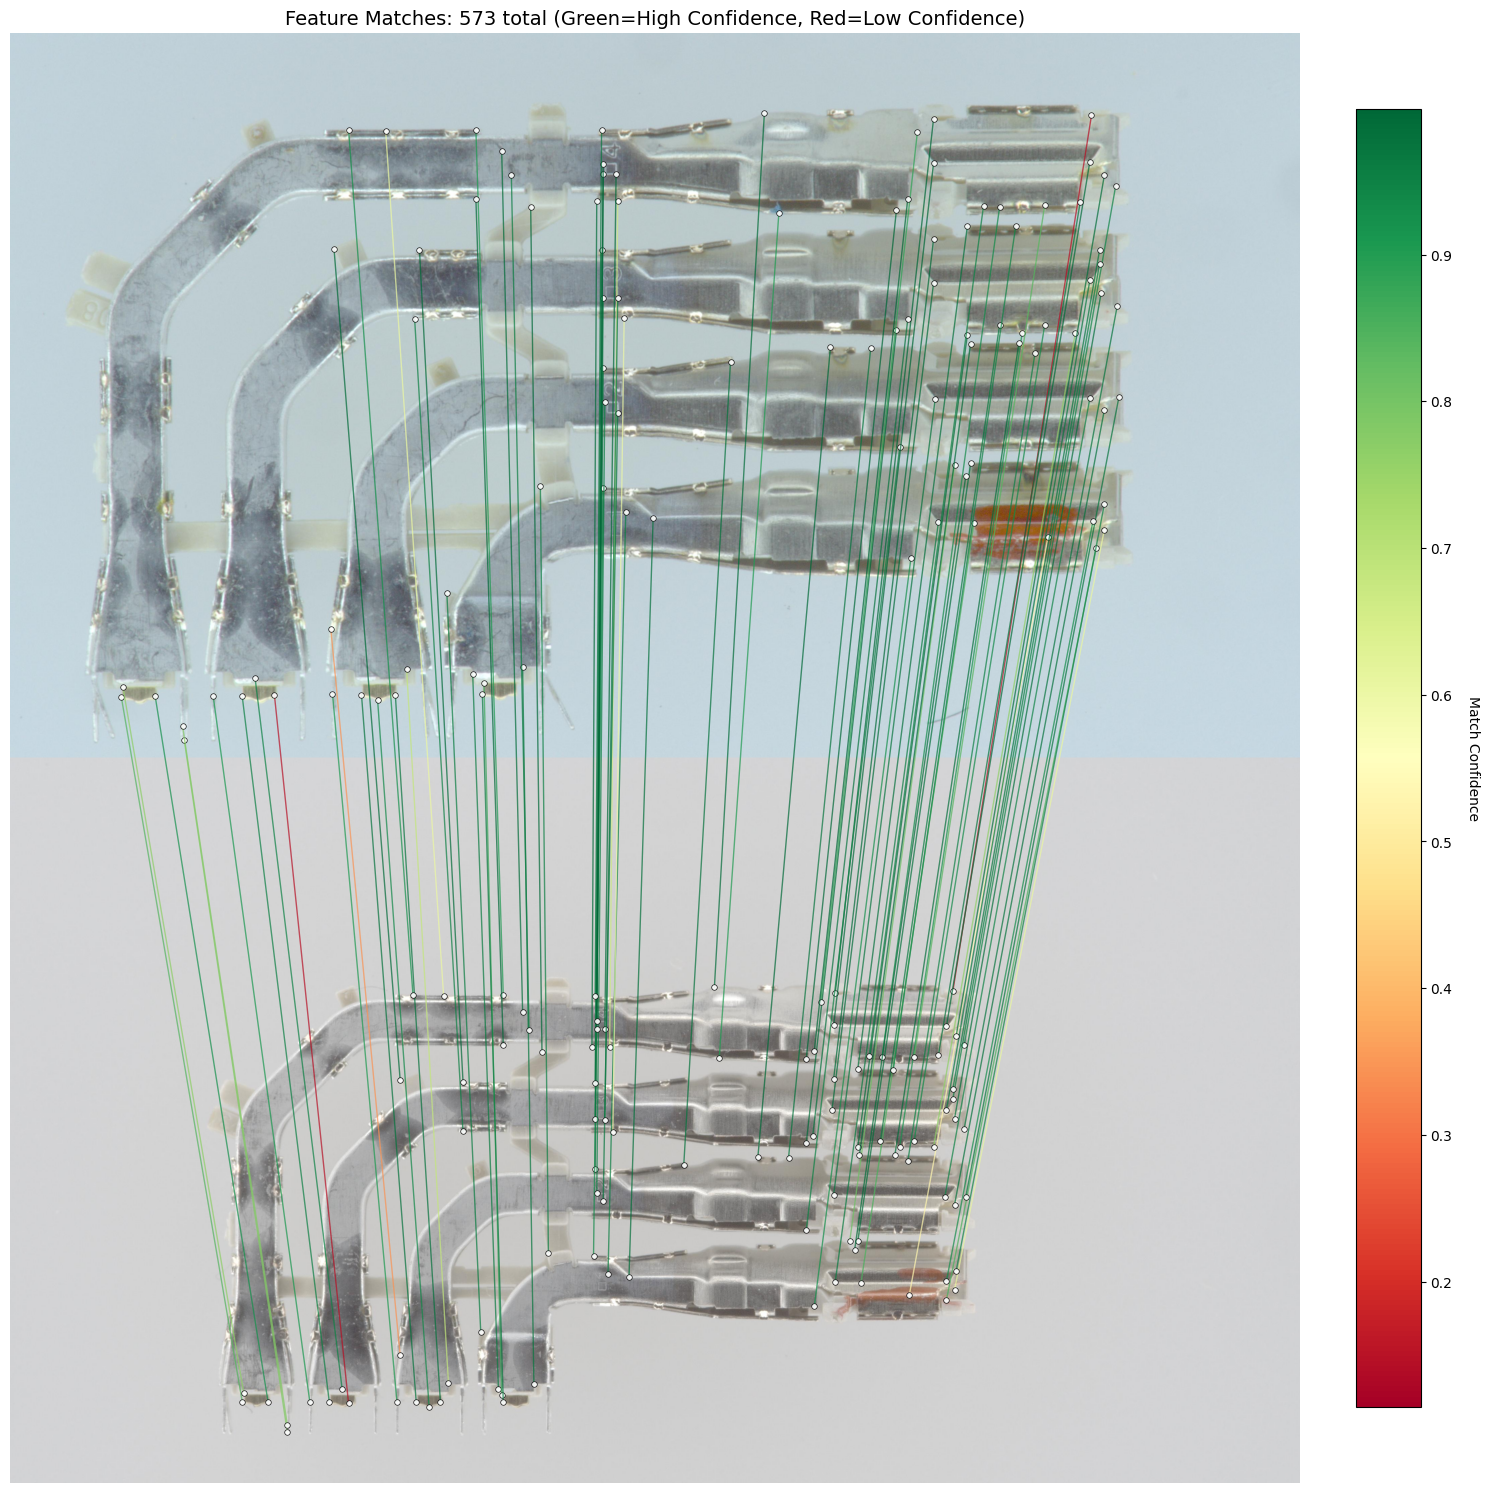


✓ Successfully validated separate extractor and matcher models!
  Template features: 1024 keypoints
  Sample features: 1024 keypoints
  Matches found: 573
  Confidence range: 0.115 - 0.999


In [5]:
# Visualize matches with confidence-based coloring
# Calculate scaling factors from 800x800 to original size
scale_x1, scale_y1 = img1.shape[1] / 800, img1.shape[0] / 800
scale_x2, scale_y2 = img2.shape[1] / 800, img2.shape[0] / 800

combined = np.vstack([img1, img2])

plt.figure(figsize=(15, 20))
plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))

# Create colormap from red (low confidence) to green (high confidence)
from matplotlib import cm
from matplotlib.colors import Normalize

# Normalize match scores to [0, 1] for colormap
norm = Normalize(vmin=mscores.min(), vmax=mscores.max())
cmap = cm.RdYlGn  # Red-Yellow-Green colormap

# Draw matches with keypoint markers
for i, match in enumerate(matches[:100]):  # Draw first 100 matches
    batch_idx = int(match[0])  # Should be 0 (both images are from same batch pair)
    idx1, idx2 = int(match[1]), int(match[2])
    
    # Get confidence score for this match
    confidence = mscores[i]
    color = cmap(norm(confidence))

    # Get keypoints from 800x800 model and scale to original size
    pt1 = kpts1[0][idx1]
    pt2 = kpts2[0][idx2]
    pt1_scaled = [pt1[0] * scale_x1, pt1[1] * scale_y1]
    pt2_scaled = [pt2[0] * scale_x2, pt2[1] * scale_y2 + img1.shape[0]]

    # Draw line with confidence-based color
    plt.plot([pt1_scaled[0], pt2_scaled[0]], [pt1_scaled[1], pt2_scaled[1]],
             color=color, linewidth=1.0, alpha=0.7)

    # Draw keypoint markers
    plt.plot(pt1_scaled[0], pt1_scaled[1], 'o', color='white', markersize=4, alpha=0.9, markeredgecolor='black', markeredgewidth=0.5)
    plt.plot(pt2_scaled[0], pt2_scaled[1], 'o', color='white', markersize=4, alpha=0.9, markeredgecolor='black', markeredgewidth=0.5)

# Add colorbar to show confidence scale
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.046, pad=0.04)
cbar.set_label('Match Confidence', rotation=270, labelpad=20)

plt.axis('off')
plt.title(f'Feature Matches: {len(matches)} total (Green=High Confidence, Red=Low Confidence)', fontsize=14)
plt.tight_layout()
plt.show()

print(f"\n✓ Successfully validated separate extractor and matcher models!")
print(f"  Template features: {len(kpts1[0])} keypoints")
print(f"  Sample features: {len(kpts2[0])} keypoints")
print(f"  Matches found: {len(matches)}")
print(f"  Confidence range: {mscores.min():.3f} - {mscores.max():.3f}")